In [827]:

import numpy as np
import dill
import importlib
import os
import matplotlib.pyplot as plt
import data_visualization as dv
import copy
import numba as nb
import time
'''
v4 Uses the object imported from the py file class which is very similar to the Optimal_Stopping_Function_v3

As of 1/13/23, the only change is the addition of the decision to action delay
'''

'\nv4 Uses the object imported from the py file class which is very similar to the Optimal_Stopping_Function_v3\n\nAs of 1/13/23, the only change is the addition of the decision to action delay\n'

In [828]:
from numba_stats import norm

In [829]:
from numba_stats import norm
import numpy as np

x = np.linspace(-10, 10)
mu = 2
sigma = 3

p = norm.pdf(x, mu, sigma)
c = norm.cdf(x, mu, sigma)

# Select Exp1 or Exp2

In [830]:
experiment = 'Exp1'

In [831]:
import read_data_functions as rdf
import plot_functions as pf
if r:
    import Optimal_Stopping_Object
    importlib.reload(Optimal_Stopping_Object)
import Optimal_Stopping_Object as oso
import Subject_Object_v2 

# Initial Thangs

In [833]:
plt.style.use('cashaback_dark')
wheel = dv.ColorWheel()

# Initial thangs
os.chdir(f'D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}')
PATH = os.getcwd()
SAVE_PATH = f'D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH+"\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
num_subjects = len(figures_pull_list)
if experiment == 'Exp2':
    tp3_title = "Win = 1\nIncorrect = 0\nIndecision = 0"
    tp4_title = "Win = 1\nIncorrect = -1\nIndecision = 0"
    tp5_title = "Win = 1\nIncorrect = 0\nIndecision = -1"
    tp6_title = "Win = 1\nIncorrect = -1\nIndecision = -1"
    trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title]
    num_blocks = len(trial_block_titles)
    xlabel = 'Payoff Condition'
if experiment == 'Exp1':
    tp3_title = "1000 (50)"
    tp4_title = "1000 (150)"
    tp5_title = '1100 (50)'
    tp6_title = "1100 (150)"
    tp7_title = "1200 (50)"
    tp8_title = '1200 (150)'
    trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]
    num_blocks = len(trial_block_titles)
    xlabel = 'Mean [SD] Agent Decision Time (ms)'
num_subjects

20

In [834]:
import scipy.special as sc


# Pickle Data

In [835]:
if 'subject_objects' not in locals():
    subject_objects = rdf.generate_subject_objects(experiment)
    subject_objects2 = copy.deepcopy(subject_objects)
    # group = Subject_Object_v2.Group(subject_objects, select_trials = 'All Trials', num_stds_for_reaction_time = 2, 
    #                                     task_leave_time_metric_name = 'player_pos_task_leave_time', task_movement_time_metric_name = 'player_pos_task_movement_time',
    #                                     reaction_time_metric_name = 'player_pos_reaction_time', reaction_movement_time_metric_name = 'player_pos_reaction_movement_time')
    # group.analyze_data()
    group = Subject_Object_v2.Group(subject_objects2, select_trials = 'All Trials', num_stds_for_reaction_time = 2, 
                                        task_leave_time_metric_name = 'player_velocity_task_leave_time_thresh',task_movement_time_metric_name = 'player_velocity_task_movement_time_thresh',
                                        reaction_time_metric_name = 'player_velocity_reaction_time_thresh', reaction_movement_time_metric_name = 'player_velocity_reaction_movement_time_thresh')
    group.analyze_data()


In [836]:
# from pyheat import PyHeat
# # os.chdir(os.getcwd())
# ph = PyHeat('D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\src\Optimal_Stopping_Object.py')
# ph.create_heatmap()

# Create Model

In [837]:
np.nanmedian(np.nanmedian(group.player_task_movement_time,axis=2))

163.5

In [838]:
if experiment == 'Exp1':
    rt                   = np.nanmedian(np.nanmedian(group.reaction_time,axis=1)) - 15
    rt_sd                = np.nanmedian(np.nanstd(group.reaction_time,axis=1))
    
elif experiment == 'Exp2':
    rt                   = np.nanmedian(np.nanmedian(group.react_reaction_time_only_react,axis=1))
    rt_sd                = np.nanmedian(np.nanstd(group.reaction_time,axis=2))

mt                   = np.min(np.nanmedian(np.nanmedian(group.player_task_movement_time,axis=2),axis=0)) # Get movement time for the condition where they tried the hardest
mt_sd                = np.nanmedian(np.nanstd(group.player_task_movement_time,axis=1))
time_sd              = np.array([np.nanmedian(np.nanstd(group.coincidence_reach_time,axis=1))]*num_blocks)
perc_wins_both_reach = np.nanmean(group.perc_gamble_wins_when_both_decide,axis=0)
gamble_sd   = np.nanmedian(np.nanstd(group.player_gamble_task_leave_time,axis=2),axis=0)
agent_sds                = np.nanmean(np.nanstd(group.agent_task_leave_time,axis=2),axis=0)
agent_means              = np.nanmean(np.nanmean(group.agent_task_leave_time,axis=2),axis=0)

# model = oso.ModelConstructor(timesteps = np.tile(np.arange(0,100.0,1),(num_blocks,1)),experiment='Exp1', num_blocks = num_blocks, BETA_ON = False,
#                                agent_means = agent_means,agent_sds = agent_sds, 
#                                reaction_time = {'true':rt,'exp':rt}, movement_time = {'true':mt,'exp':mt},
#                                reaction_sd = {'true':rt_sd,'exp':rt_sd}, movement_sd = {'true':mt_sd,'exp':mt_sd},
#                                timing_sd = {'true':time_sd,'exp':time_sd},
#                                perc_wins_when_both_reach = perc_wins_both_reach,
#                                gamble_delay_known = True, gamble_sd_known = True,
#                                gamble_sd= {'true':150,'exp':10}, gamble_delay = {'true':125,'exp':50},
#                             )
start = time.time()
model_expected = oso.ModelConstructor(experiment='Exp1', num_blocks = num_blocks, num_timesteps = 1800, BETA_ON = False,\
                               agent_means = agent_means,agent_sds = agent_sds, \
                               reaction_time = {'true':rt,'exp':rt}, movement_time = {'true':mt,'exp':mt},\
                               reaction_sd = {'true':rt_sd,'exp':rt_sd}, movement_sd = {'true':mt_sd,'exp':mt_sd},\
                               timing_sd = {'true':time_sd,'exp':time_sd},\
                               perc_wins_when_both_reach = perc_wins_both_reach,\
                               gamble_delay_known = True, gamble_sd_known = True,\
                               gamble_decision_sd= {'true':gamble_sd,'exp':10}, gamble_delay = {'true':125,'exp':50},\
                               expected=True,
                            )
model_true = oso.ModelConstructor(experiment='Exp1', num_blocks = num_blocks,num_timesteps = 1800, BETA_ON = False,\
                               agent_means = agent_means,agent_sds = agent_sds, \
                               reaction_time = {'true':rt,'exp':rt}, movement_time = {'true':mt,'exp':mt},\
                               reaction_sd = {'true':rt_sd,'exp':rt_sd}, movement_sd = {'true':mt_sd,'exp':mt_sd},\
                               timing_sd = {'true':time_sd,'exp':time_sd},\
                               perc_wins_when_both_reach = perc_wins_both_reach,\
                               gamble_delay_known = True, gamble_sd_known = True,\
                               gamble_decision_sd= {'true':gamble_sd,'exp':10}, gamble_delay = {'true':125,'exp':50},\
                               expected=False,
                            )
end = time.time()
print(end-start)

5.995483160018921


# Tune Model

In [839]:
@nb.njit(parallel=False)
def get_metric_decision_time_for_certain_metric(rts,mts):
    # print(type(rts))
    a = 5+2
    ans = np.empty((4,4,4))
    for i in range(len(rts)):
        for j in range(len(mts)):
            pass
            # ob.reaction_time = rts[i]
            # ob.movement_time = mts[j]
            # ob.run_model()
            # ans[i,j,:] = ob.optimal_decision_time 
    return ans

In [840]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.9f}".format(x)})
o = model_true
print(f'Reaction Time Mean (SD):    {o.inputs.reaction_time["exp"]:0.3f} ({o.inputs.reaction_sd["exp"]:0.3f})')
print(f'Movement Time Mean (SD):    {o.inputs.movement_time["exp"]:0.3f} ({o.inputs.movement_sd["exp"]:0.3f})')
print(f'Timing Uncertainty:         {o.inputs.timing_sd["exp"]}')
print(f'True Gamble Delay:          {o.inputs.gamble_delay["true"]}')
print(f'Expected Gamble Delay:      {o.inputs.gamble_delay["exp"]}')
print(f'True Gamble Uncertainty:     {o.inputs.gamble_decision_sd["true"]}')
print(f'Expected Gamble Uncertainty: {o.inputs.gamble_decision_sd["exp"]}')

Reaction Time Mean (SD):    251.250 (37.695)
Movement Time Mean (SD):    157.250 (26.543)
Timing Uncertainty:         [76.613683280 76.613683280 76.613683280 76.613683280 76.613683280
 76.613683280]
True Gamble Delay:          125
Expected Gamble Delay:      50
True Gamble Uncertainty:     [74.730052475 115.394910923 90.163114907 121.345299324 137.262017583
 136.978197553]
Expected Gamble Uncertainty: 10


In [841]:
model_expected.results.get_metric(metric=model_true.player_behavior.wtd_leave_target_time)

array([1250.556492841, 1217.861339859, 1249.527615488, 1236.947822498,
       970.020749492, 1211.294166263])

In [842]:
model_true.fit_model(model_true.player_behavior.wtd_leave_target_time,
                           np.nanmedian(np.nanmedian(group.player_task_leave_time,axis=2),axis=0),
                           )
model_expected.fit_model(model_expected.player_behavior.wtd_leave_target_time,
                           np.nanmedian(np.nanmedian(group.player_task_leave_time,axis=2),axis=0),
                           )

## Shorten the function name

In [843]:
get_metric = model_true.results.get_metric
reaction_gamble_metric = model_true.results.reaction_gamble_metric
#! EXAMPLE
#* Always use the true values to get the metric (function call)
#* But metric_type 'optimal' or 'fit' determines if I use optimal decision index or fit decision index
#* If 
get_metric(model_true.score_metrics.prob_incorrect,metric_type='fit') 

array([0.102363846, 0.113029674, 0.228066680, 0.225136809, 0.400622105,
       0.342878907])

# NOTE

## IMPORTANT!
When Known is False, then the optimal_model_full_knowledge.true_metric will be what happens when I pick an optimal based on what I THINK my delay is, 

and then I actually get the metric where the true values apply

## Less important

- Fitting to the TRUE gamble delay gives EARLIER stopping time
- Fitting to the TRUE gamble uncertainty should not impact the stopping time (NEED TO CHECK THIS)

- EARLIER stopping time, means less gamble indecisions, and less reaction 

- *OPTIMAL_TRUE metrics ALWAYS account for the true gamble delay and uncertainty, regardless of known or unknown or what the expected gamble and uncertainty are
----
- Group model true fits to the wtd_optimal_true_leave_target_time
    - MEANING, that it selects the OPTIMAL STOPPING TIME using the GAMBLE DELAY = 150 and GAMBLE UNCERTAINTY = FROM DATA
----
- Group model expected fits to the wtd_optimal_EXPECTED_leave_target_time
    - MEANING, that it selects the OPTIMAL STOPPING TIME using the GAMBLE DELAY = 50 and GAMBLE UNCERTAINTY = timing_sd + 10
----
WHEN KNOWN IS FALSE
- AND I FIT STOPPING TIME TO THE TRUE GAMBLE STUFF
    - THEN EXPECTED METRICS for that model WILL BE THE RESULT OF fitting to some gamble delay, but not incorporating that gamble delay/uncertainty into the prediction of the metrics
    - So that's like participants picking a stopping time 

In [844]:
# optimal_model_full_knowledge.plot_optimals(metrics = ['exp_reward','prob_making_given_reaction','prob_indecision_given_reaction','prob_agent_has_gone'])#,'exp_reward_reaction','exp_reward_gamble','prob_selecting_reaction'])

# Plots

In [845]:
save = False

Predicted Decision Time

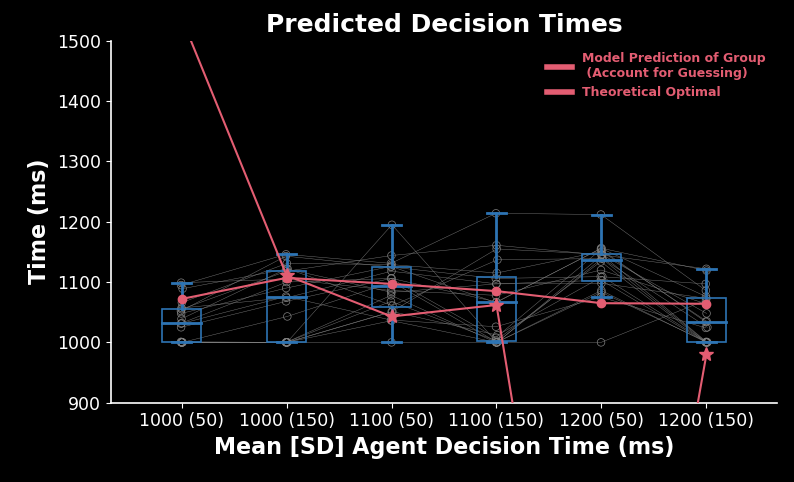

In [846]:
group.predict_stopping_times(model_true.inputs.gamble_delay['true'])
metric = group.combine_all_subjects('player_stopping_times')
group_model_metric_true       = model_true.results.fit_decision_time
group_model_metric_expected   = model_expected.results.fit_decision_time
optimal_model_metric_true     = model_true.results.optimal_decision_time
optimal_model_metric_expected = model_expected.results.optimal_decision_time
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(900,1600,100)
bw = 0.75
pf.multiple_models_boxplot(ax,metric,show_boxplot=True,
                           group_model_true = group_model_metric_true, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =None,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,linestyles = ['-']*4,
                            remove_parentheses_from_labels = False)

ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel(xlabel)
ax.set_ylabel('Time (ms)')
ax.set_title('Predicted Decision Times')
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

LEave Target Time

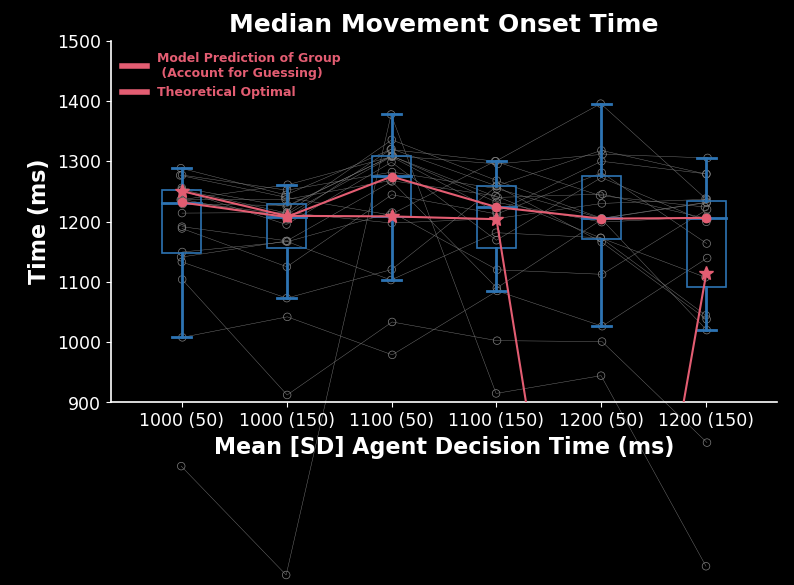

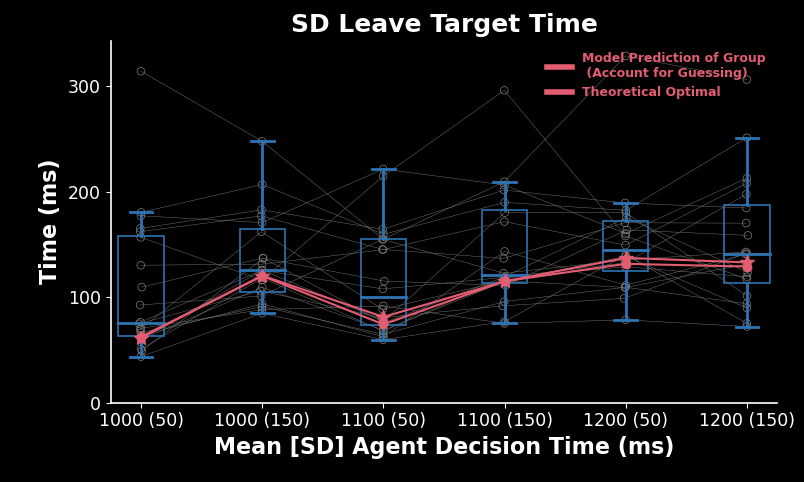

In [847]:
metric = np.nanmedian(group.player_task_leave_time,axis=2)
group_model_metric_true       = get_metric(model_true.player_behavior.wtd_leave_target_time,metric_type='fit')
group_model_metric_expected   = get_metric(model_expected.player_behavior.wtd_leave_target_time,metric_type='fit')
optimal_model_metric_true     = get_metric(model_true.player_behavior.wtd_leave_target_time)
optimal_model_metric_expected = get_metric(model_expected.player_behavior.wtd_leave_target_time)
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(900,1600,100)
bw = 0.75
pf.multiple_models_boxplot(ax,metric,show_boxplot=True,
                           group_model_true = group_model_metric_true, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_optimal_model_expected =optimal_model_metric_expected,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,linestyles = ['-']*4,
                            remove_parentheses_from_labels = False)

ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel(xlabel)
ax.set_ylabel('Time (ms)')
ax.set_title('Median Movement Onset Time')
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

metric = np.nanstd(group.player_task_leave_time,axis=2)
group_model_metric_true       = get_metric(model_true.player_behavior.wtd_leave_target_time_sd,metric_type='fit')
group_model_metric_expected   = get_metric(model_expected.player_behavior.wtd_leave_target_time_sd,metric_type='fit')
optimal_model_metric_true     = get_metric(model_true.player_behavior.wtd_leave_target_time_sd)
optimal_model_metric_expected = get_metric(model_expected.player_behavior.wtd_leave_target_time_sd)
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,400,100)
bw = 0.75
pf.multiple_models_boxplot(ax,metric,show_boxplot=True,
                           group_model_true = group_model_metric_true, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,model_expected =None,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,linestyles = ['-']*4,
                           remove_parentheses_from_labels = False,legend_loc ='upper right',)

ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
# ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xlabel(xlabel)
ax.set_ylabel('Time (ms)')
ax.set_title('SD Leave Target Time')
# ax.plot(xlocs,np.sqrt(model_expected.gamble_reach_time_sd**2))
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()
plt.show()

Wins

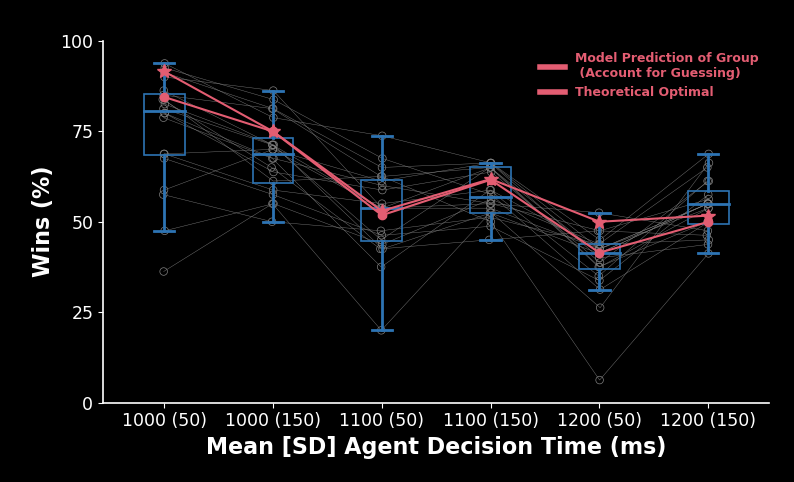

In [848]:
metric = group.player_perc_wins
group_model_metric_true       = get_metric(model_true.score_metrics.prob_win,metric_type='fit')*100
group_model_metric_expected   = get_metric(model_expected.score_metrics.prob_win,metric_type='fit')*100
optimal_model_metric_true     = get_metric(model_true.score_metrics.prob_win)*100
optimal_model_metric_expected = get_metric(model_expected.score_metrics.prob_win)*100
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
pf.multiple_models_boxplot(ax,metric,
                           group_model_true = group_model_metric_true, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_optimal_model_expected =optimal_model_metric_expected,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,remove_parentheses_from_labels=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel(xlabel)
ax.set_ylabel('Wins (%)')
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'wins_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Points

In [849]:
if experiment == 'Exp2':
    metric = group.player_points_scored

    optimal_model_metric_true = optimal_model_full_knowledge.max_exp_reward*group.num_task_trials[0]
    group_model_metric_true = group_model_true_true.expected_reward_of_decision_time*group.num_task_trials[0]
    optimal_model_metric_expected = optimal_model_no_knowledge.max_exp_reward*group.num_task_trials[0]
    group_model_metric_expected = (model_expected.expected_reward_of_decision_time*group.num_task_trials[0])

    w,h = 10,6
    axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
    xlocs = np.linspace(0,w,num=len(trial_block_titles))
    ylocs = np.arange(-80,100,40)

    bw = 0.75
    pf.multiple_models_boxplot(ax,metric, model.inputs.gamble_delay['true'] ,true_gamble_sd = model.inputs.gamble_decision_sd['true'], 
                               expected_gamble_delay=model.inputs.gamble_delay['exp'],expected_gamble_sd=model.inputs.gamble_delay['exp'],
                               group_model_true = None, group_model_expected = None, 
                            optimal_model_true = optimal_model_metric_true,optimal_model_expected =optimal_model_metric_expected,
                            xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)

    ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
    ax.set_xticks(xlocs),ax.set_yticks(ylocs)
    ax.set_xticklabels(trial_block_titles)
    # ax.set_ylim(0,100)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Points Scored')
    # dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])
    if save:
        axmain.set_axis_off()
        plt.savefig(SAVE_PATH+'wins_with_optimal_model', dpi = 400, transparent = True)
    axmain.set_axis_off()
    plt.show()

Incorrects

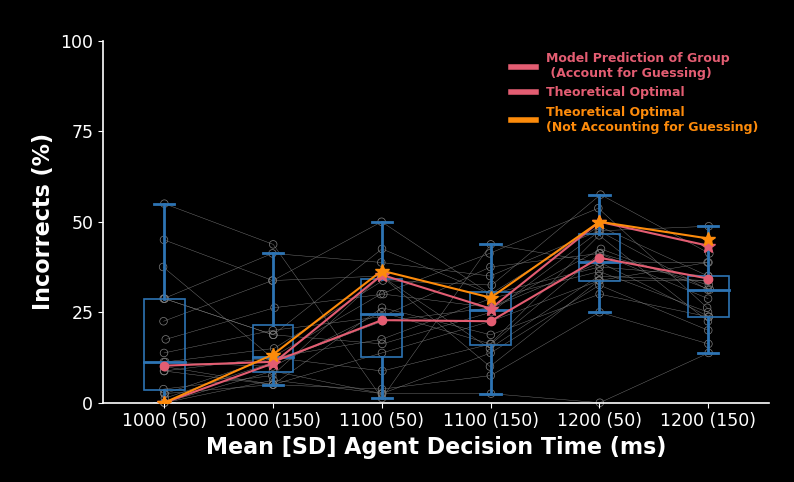

In [850]:
metric = group.player_perc_incorrects
group_model_metric_true       = get_metric(model_true.score_metrics.prob_incorrect,metric_type='fit')*100
group_model_metric_expected   = get_metric(model_expected.score_metrics.prob_incorrect,metric_type='fit')*100
optimal_model_metric_true     = get_metric(model_true.score_metrics.prob_incorrect)*100
optimal_model_metric_expected = get_metric(model_expected.score_metrics.prob_incorrect)*100

w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
pf.multiple_models_boxplot(ax,metric,
                           group_model_true = group_model_metric_true, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =optimal_model_metric_expected,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,remove_parentheses_from_labels=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel(xlabel)
ax.set_ylabel('Incorrects (%)')
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'incorrects_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Indecisions

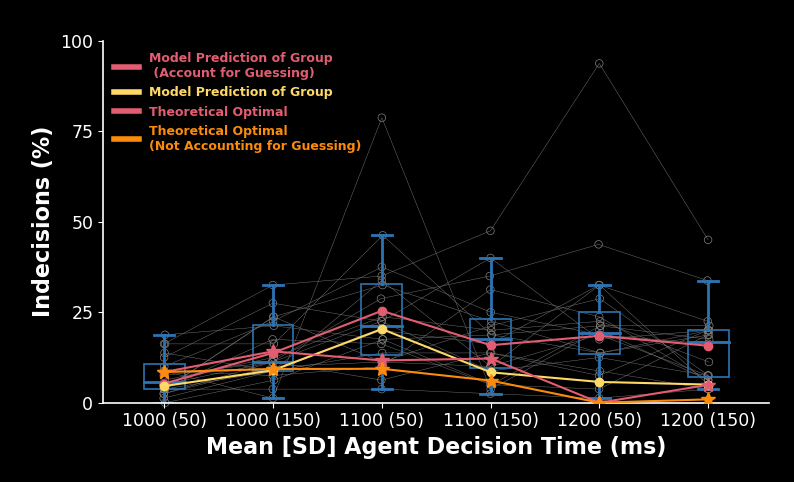

In [865]:
metric = group.player_perc_indecisions
group_model_metric_true       = get_metric(model_true.score_metrics.prob_indecision,metric_type='fit')*100
group_model_metric_expected   = get_metric(model_expected.score_metrics.prob_indecision,metric_type='fit')*100
optimal_model_metric_true     = get_metric(model_true.score_metrics.prob_indecision)*100
optimal_model_metric_expected = get_metric(model_expected.score_metrics.prob_indecision)*100

w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
pf.multiple_models_boxplot(ax,metric,
                           group_model_true = group_model_metric_true, group_model_expected = group_model_metric_expected, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =optimal_model_metric_expected,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,remove_parentheses_from_labels=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel(xlabel)
ax.set_ylabel('Indecisions (%)')

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'indecisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

<Optimal_Stopping_Object.Results object at 0x0000016D828D48E0>

In [871]:
model_true.results.fit_decision_time

array([1072.000000000, 1107.000000000, 1097.000000000, 1085.000000000,
       1065.000000000, 1064.000000000])

In [870]:
model_expected.results.fit_decision_time

array([1100.000000000, 1144.000000000, 1127.000000000, 1126.000000000,
       1113.000000000, 1115.000000000])

Wins, Incorrects, Indecisions on One plot

Correct Initial Decisions

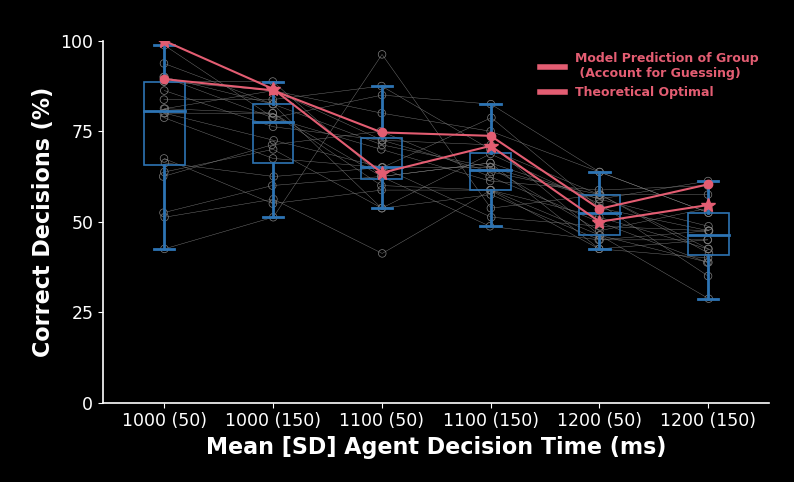

In [852]:
metric = group.phat_correct*100 
group_model_metric_true       = get_metric(model_true.score_metrics.correct_decisions,metric_type='fit')*100
group_model_metric_expected   = get_metric(model_expected.score_metrics.correct_decisions,metric_type='fit')*100
optimal_model_metric_true     = get_metric(model_true.score_metrics.correct_decisions)*100
optimal_model_metric_expected = get_metric(model_expected.score_metrics.correct_decisions)*100

w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
pf.multiple_models_boxplot(ax,metric,group_model_true = group_model_metric_true, group_model_expected = None, 
                           optimal_model_true = optimal_model_metric_true,optimal_model_expected =None,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel(xlabel)
ax.set_ylabel('Correct Decisions (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'incorrects_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Decisions

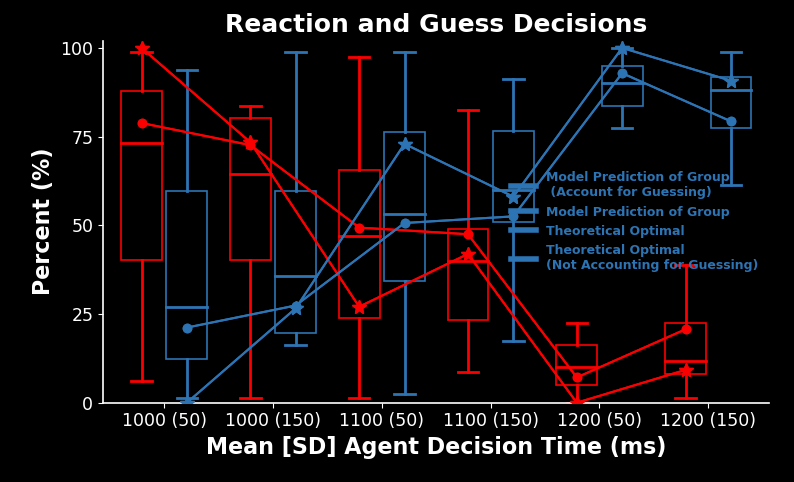

In [853]:
group_model_metric1_expected     = get_metric(model_expected.player_behavior.prob_selecting_reaction,metric_type='fit')*100
group_model_metric2_expected     = get_metric(model_expected.player_behavior.prob_selecting_gamble,metric_type='fit')*100
group_model_metric1_true         = get_metric(model_true.player_behavior.prob_selecting_reaction,metric_type='fit')*100
group_model_metric2_true         = get_metric(model_true.player_behavior.prob_selecting_gamble,metric_type='fit')*100

optimal_model_metric1_expected   = get_metric(model_expected.player_behavior.prob_selecting_reaction)*100
optimal_model_metric2_expected   = get_metric(model_expected.player_behavior.prob_selecting_gamble)*100
optimal_model_metric1_true       = get_metric(model_true.player_behavior.prob_selecting_reaction)*100
optimal_model_metric2_true       = get_metric(model_true.player_behavior.prob_selecting_gamble)*100

data_metric1 = group.combine_all_subjects('perc_reaction_decisions')
data_metric2 = group.combine_all_subjects('perc_gamble_decisions')

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           optimal_model_true = optimal_model_metric1_true, optimal_model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           optimal_model_true = optimal_model_metric2_true, optimal_model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title('Reaction and Guess Decisions')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Leave Times

c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


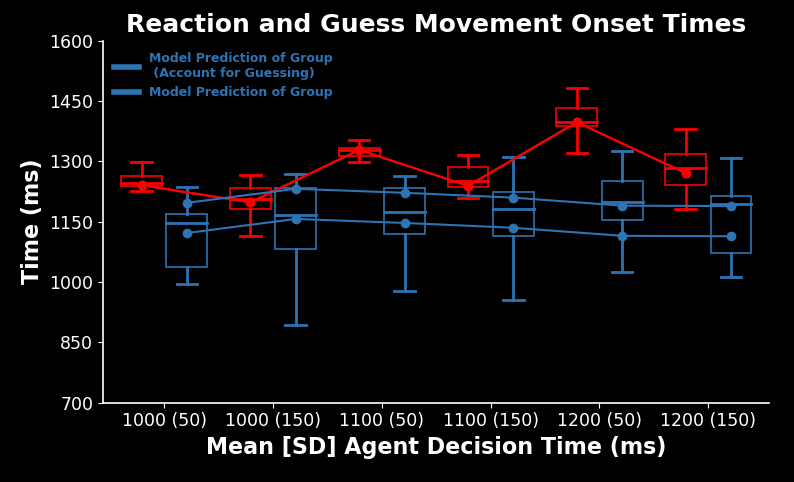

In [854]:
data_metric1 = np.nanmedian(group.player_reaction_task_leave_time,axis=2)
data_metric2 = np.nanmedian(group.player_gamble_task_leave_time,axis=2)

group_model_metric1_expected     = get_metric(model_expected.player_behavior.reaction_leave_time,metric_type='fit')
group_model_metric2_expected     = get_metric(model_expected.player_behavior.gamble_leave_time,metric_type='fit')
group_model_metric1_true         = get_metric(model_true.player_behavior.reaction_leave_time,metric_type='fit')
group_model_metric2_true         = get_metric(model_true.player_behavior.gamble_leave_time,metric_type='fit')

optimal_model_metric1_expected   = get_metric(model_expected.player_behavior.reaction_leave_time)
optimal_model_metric2_expected   = get_metric(model_expected.player_behavior.gamble_leave_time)
optimal_model_metric1_true       = get_metric(model_true.player_behavior.reaction_leave_time)
optimal_model_metric2_true       = get_metric(model_true.player_behavior.gamble_leave_time)

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(700,1750,150)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           optimal_model_true = None,optimal_model_expected =None,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           optimal_model_true = None,optimal_model_expected =None,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)
 
ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Time (ms)')
ax.set_xlabel(xlabel)
ax.set_title('Reaction and Guess Movement Onset Times')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Agent Reaction and Guess Decision Times

c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


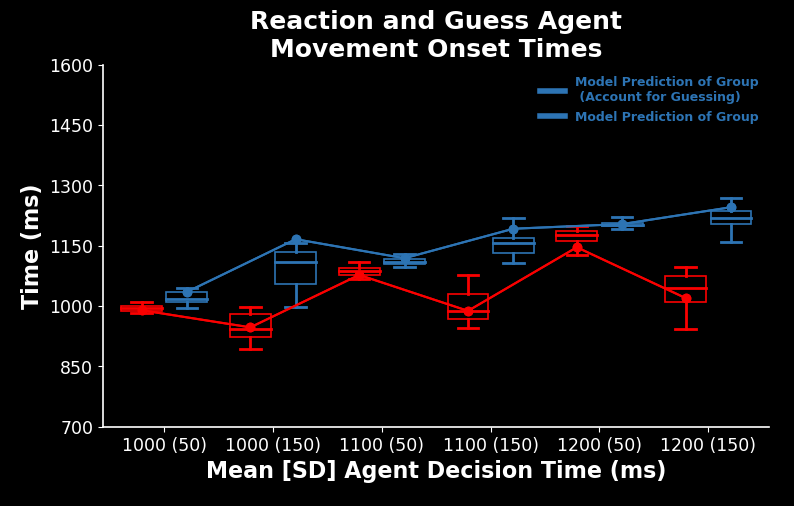

In [855]:

data_metric1 = np.nanmedian(group.agent_reaction_task_leave_time,axis=2)
data_metric2 = np.nanmedian(group.agent_gamble_task_leave_time,axis=2)

group_model_metric1_expected     = get_metric(model_expected.agent_behavior.reaction_leave_time,metric_type='fit')
group_model_metric2_expected     = get_metric(model_expected.agent_behavior.gamble_leave_time,metric_type='fit')
group_model_metric1_true         = get_metric(model_true.agent_behavior.reaction_leave_time,metric_type='fit')
group_model_metric2_true         = get_metric(model_true.agent_behavior.gamble_leave_time,metric_type='fit')

optimal_model_metric1_expected   = get_metric(model_expected.agent_behavior.reaction_leave_time)
optimal_model_metric2_expected   = get_metric(model_expected.agent_behavior.gamble_leave_time)
optimal_model_metric1_true       = get_metric(model_true.agent_behavior.reaction_leave_time)
optimal_model_metric2_true       = get_metric(model_true.agent_behavior.gamble_leave_time)

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(700,1750,150)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           model_true = optimal_model_metric1_true,model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           model_true = optimal_model_metric2_true,model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Time (ms)')
ax.set_xlabel(xlabel)
ax.set_title('Reaction and Guess Agent\nMovement Onset Times')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent Indecisions That Were Reaction/Gamble

In [856]:
get_metric(model_expected.score_metrics.prob_indecision,metric_type='fit')

array([0.045948032, 0.089616529, 0.203570215, 0.083965294, 0.057387907,
       0.050080477])

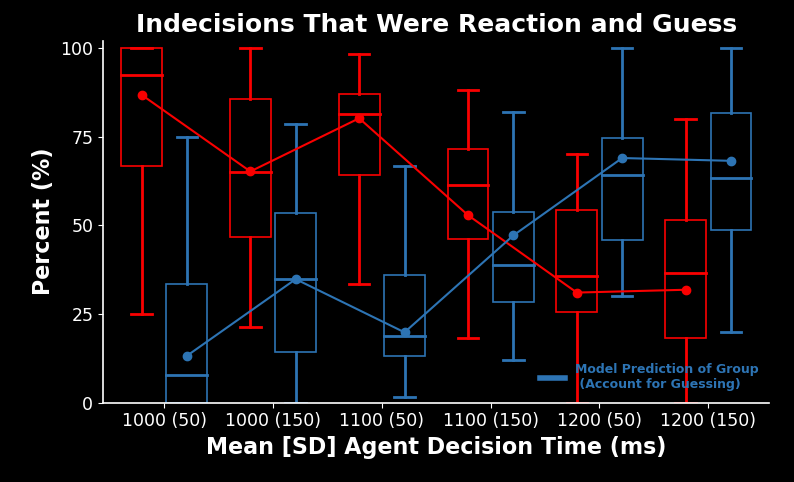

In [858]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric1 = group.perc_indecisions_that_were_reactions 
data_metric2 = group.perc_indecisions_that_were_gambles 

group_model_metric1_expected     = reaction_gamble_metric(model_expected.score_metrics.prob_indecision_reaction,
                                                                             model_expected.score_metrics.prob_indecision,
                                                                             metric_type='fit')
group_model_metric1_true         = reaction_gamble_metric(model_true.score_metrics.prob_indecision_reaction,
                                                                             model_true.score_metrics.prob_indecision,
                                                                             metric_type='fit')

optimal_model_metric1_expected   = reaction_gamble_metric(model_expected.score_metrics.prob_indecision_reaction,
                                                                             model_expected.score_metrics.prob_indecision)
optimal_model_metric1_true       = reaction_gamble_metric(model_true.score_metrics.prob_indecision_reaction,
                                                                             model_true.score_metrics.prob_indecision)

group_model_metric2_expected     = reaction_gamble_metric(model_expected.score_metrics.prob_indecision_gamble,
                                                                             model_expected.score_metrics.prob_indecision,
                                                                             metric_type='fit')
group_model_metric2_true         = reaction_gamble_metric(model_true.score_metrics.prob_indecision_gamble,
                                                                             model_true.score_metrics.prob_indecision,
                                                                             metric_type='fit')

optimal_model_metric2_expected   = reaction_gamble_metric(model_expected.score_metrics.prob_indecision_gamble,
                                                                             model_expected.score_metrics.prob_indecision)
optimal_model_metric2_true       = reaction_gamble_metric(model_true.score_metrics.prob_indecision_gamble,
                                                                             model_true.score_metrics.prob_indecision)

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = None, 
                           optimal_model_true = None,optimal_model_expected =None,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = None, 
                           optimal_model_true = None,optimal_model_expected =None,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title('Indecisions That Were Reaction and Guess')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Indecisions That Were Gamble

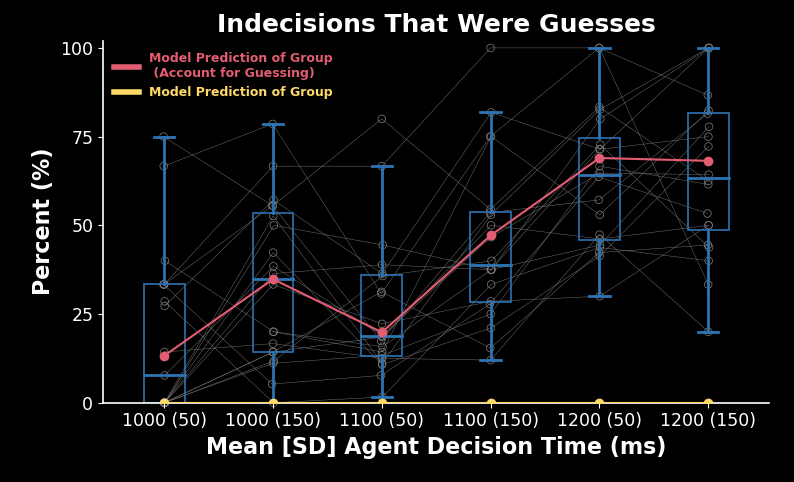

In [861]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric2 = group.perc_indecisions_that_were_gambles 

group_model_metric2_expected     = reaction_gamble_metric(model_expected.score_metrics.prob_indecision_gamble,
                                                          model_expected.score_metrics.prob_indecision,
                                                          metric_type='fit')
group_model_metric2_true         = reaction_gamble_metric(model_true.score_metrics.prob_indecision_gamble,
                                                          model_true.score_metrics.prob_indecision,
                                                          metric_type='fit')
optimal_model_metric2_expected   = reaction_gamble_metric(model_expected.score_metrics.prob_indecision_gamble,
                                                                             model_expected.score_metrics.prob_indecision)
optimal_model_metric2_true       = reaction_gamble_metric(model_true.score_metrics.prob_indecision_gamble,
                                                                             model_true.score_metrics.prob_indecision)

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           model_true = optimal_model_metric2_true, model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs,box_width = bw,colors = wheel.seth_blue,line_colors = None,jitter=True,remove_parentheses_from_labels=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title('Indecisions That Were Guesses')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

In [860]:
# Out of x number of wins, how many were Reaction and Guess
data_metric1 = group.perc_wins_that_were_reactions 
data_metric2 = group.perc_wins_that_were_gambles 
group_model_metric1_expected     = model_expected.optimal_expected_prob_wins_that_were_reaction*100
group_model_metric1_true         = group_model_true.optimal_true_prob_wins_that_were_reaction*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_wins_that_were_reaction*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_wins_that_were_reaction*100

group_model_metric2_expected     = model_expected.optimal_expected_prob_wins_that_were_gamble*100
group_model_metric2_true         = group_model_true.optimal_true_prob_wins_that_were_gamble*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_wins_that_were_gamble*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_wins_that_were_gamble*100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           model_true = optimal_model_metric1_true, model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           model_true = optimal_model_metric2_true, model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title('Wins That Were Reaction and Guess')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

AttributeError: 'ModelConstructor' object has no attribute 'optimal_expected_prob_wins_that_were_reaction'

Incorrects that were Reaction and Guess

In [ ]:
# Out of x number of incorrects, how many were Reaction and Guess
data_metric1 = group.perc_incorrects_that_were_reactions 
data_metric2 = group.perc_incorrects_that_were_gambles 
group_model_metric1_expected     = model_expected.optimal_expected_prob_incorrects_that_were_reaction*100
group_model_metric1_true         = group_model_true.optimal_true_prob_incorrects_that_were_reaction*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_incorrects_that_were_reaction*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_incorrects_that_were_reaction*100

group_model_metric2_expected     = model_expected.optimal_expected_prob_incorrects_that_were_gamble*100
group_model_metric2_true         = group_model_true.optimal_true_prob_incorrects_that_were_gamble*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_incorrects_that_were_gamble*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_incorrects_that_were_gamble*100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           model_true = optimal_model_metric1_true, model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           model_true = optimal_model_metric2_true, model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title('Incorrects That Were Reaction and Guess')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

AttributeError: 'ModelConstructor' object has no attribute 'optimal_expected_prob_incorrects_that_were_reaction'

OUt of the Reaction/Gamble How many times did they win

In [ ]:
# Out of x number of, wins how many were Reaction and Guess
data_metric1 = group.perc_reactions_that_were_wins 
data_metric2 = group.perc_gambles_that_were_wins 
group_model_metric1_expected     = model_expected.optimal_expected_prob_reactions_that_were_wins*100
group_model_metric1_true         = group_model_true.optimal_true_prob_reactions_that_were_wins*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_reactions_that_were_wins*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_reactions_that_were_wins*100

group_model_metric2_expected     = model_expected.optimal_expected_prob_gambles_that_were_wins*100
group_model_metric2_true         = group_model_true.optimal_true_prob_gambles_that_were_wins*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_gambles_that_were_wins*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_gambles_that_were_wins*100

# Out of x number of Reaction and Guess decisions, how many of them were
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           model_true = optimal_model_metric1_true,model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           model_true = optimal_model_metric2_true,model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title( 'Prob Reaction/Gamble That Were Wins')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent Reaction and Guess That Were Indecisions 

In [ ]:
# Out of x number of, incorrects how many were Reaction and Guess
data_metric1 = group.perc_reactions_that_were_incorrects 
data_metric2 = group.perc_gambles_that_were_incorrects 
group_model_metric1_expected     = model_expected.optimal_expected_prob_reactions_that_were_incorrects*100
group_model_metric1_true         = group_model_true.optimal_true_prob_reactions_that_were_incorrects*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_reactions_that_were_incorrects*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_reactions_that_were_incorrects*100

group_model_metric2_expected     = model_expected.optimal_expected_prob_gambles_that_were_incorrects*100
group_model_metric2_true         = group_model_true.optimal_true_prob_gambles_that_were_incorrects*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_gambles_that_were_incorrects*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_gambles_that_were_incorrects*100

# Out of x number of Reaction and Guess decisions, how many of them were
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           model_true = optimal_model_metric1_true,model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           model_true = optimal_model_metric2_true,model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title( 'Prob Reaction/Gamble That Were Incorrects')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

In [ ]:
# Out of x number of, indecisions how many were Reaction and Guess
data_metric1 = group.perc_reactions_that_were_indecisions 
data_metric2 = group.perc_gambles_that_were_indecisions 
group_model_metric1_expected     = model_expected.optimal_expected_prob_reactions_that_were_indecisions*100
group_model_metric1_true         = group_model_true.optimal_true_prob_reactions_that_were_indecisions*100
optimal_model_metric1_expected   = optimal_model_full_knowledge.optimal_expected_prob_reactions_that_were_indecisions*100
optimal_model_metric1_true = optimal_model_full_knowledge.optimal_true_prob_reactions_that_were_indecisions*100

group_model_metric2_expected     = model_expected.optimal_expected_prob_gambles_that_were_indecisions*100
group_model_metric2_true         = group_model_true.optimal_true_prob_gambles_that_were_indecisions*100
optimal_model_metric2_expected   = optimal_model_full_knowledge.optimal_expected_prob_gambles_that_were_indecisions*100
optimal_model_metric2_true = optimal_model_full_knowledge.optimal_true_prob_gambles_that_were_indecisions*100

# Out of x number of Reaction and Guess decisions, how many of them were
w,h = 10,6
axmain,ax = pf.make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
pf.multiple_models_boxplot(ax,data_metric1,group_model_true = group_model_metric1_true, group_model_expected = group_model_metric1_expected, 
                           model_true = optimal_model_metric1_true,model_expected =optimal_model_metric1_expected,
                           xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red,line_colors = [wheel.seth_red]*4,jitter=False)

pf.multiple_models_boxplot(ax,data_metric2,group_model_true = group_model_metric2_true, group_model_expected = group_model_metric2_expected, 
                           model_true = optimal_model_metric2_true,model_expected =optimal_model_metric2_expected,
                           xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue,line_colors = [wheel.seth_blue]*4,jitter=False)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel(xlabel)
ax.set_title( 'Prob Reaction/Gamble That Were Indecisions')
# dv.custom_legend(ax,['Reaction','Gamble'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()